🟦 CELL 1 – Import & konfigurasi folder (lanjutan dari yang sudah ada)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Folder yang sudah ada
FOLDER_GAITFRAME = r"E:\1.Clustering_TA\dataset\gaitframe"

# Folder baru untuk menyimpan gait frame + gait signal + step event
FOLDER_GAITFRAME_STEPS = r"E:\1.Clustering_TA\dataset\gaitframe_steps"
os.makedirs(FOLDER_GAITFRAME_STEPS, exist_ok=True)

def convert_timestamp_to_seconds(ts):
    """
    Konversi string timestamp 'HH:MM:SS.microsec' ke detik float.
    Jika gagal parse → return NaN.
    """
    try:
        h, m, s = ts.split(":")
        return int(h) * 3600 + int(m) * 60 + float(s)
    except:
        return np.nan


🟦 CELL 2 – Fungsi untuk membangun gait signal & estimasi fps

In [2]:
def compute_gait_signal(df_gait, smooth_window=5):
    """
    Menambahkan kolom:
    - gait_signal_raw   = |doppler_torso|
    - gait_signal_smooth= rolling median dari gait_signal_raw
    Sekaligus mengestimasi fps (frame per second) dari timestamp_sec.
    """

    df = df_gait.copy()

    # Pastikan kolom yang dibutuhkan ada
    required_cols = ["doppler_torso", "is_gap", "timestamp_sec"]
    for c in required_cols:
        if c not in df.columns:
            raise ValueError(f"Kolom '{c}' tidak ditemukan di df_gait")

    # Gait signal mentah: |doppler_torso|
    df["gait_signal_raw"] = df["doppler_torso"].abs()

    # Smoothing sederhana: rolling median
    df["gait_signal_smooth"] = (
        df["gait_signal_raw"]
        .rolling(window=smooth_window, center=True, min_periods=1)
        .median()
    )

    # Estimasi fps (sampling rate) dari frame valid (no gap, doppler_torso bukan NaN)
    valid_mask = (df["is_gap"] == 0) & df["timestamp_sec"].notna()
    ts_valid = df.loc[valid_mask, "timestamp_sec"].values

    if len(ts_valid) < 3:
        fps = np.nan
    else:
        dt = np.diff(ts_valid)
        dt = dt[dt > 0]  # buang anomali nol/negatif
        if len(dt) == 0:
            fps = np.nan
        else:
            dt_median = np.median(dt)
            fps = 1.0 / dt_median if dt_median > 0 else np.nan

    return df, fps


🟦 CELL 3 – Fungsi step detection (peak detection ala jurnal)

In [3]:
def detect_steps_in_gait_frame(
    df_gait,
    fps,
    min_step_time=0.3,
    max_step_time=1.5,
    threshold_alpha=0.4
):
    """
    Mendeteksi langkah dari gait_signal_smooth.

    Parameter:
    - fps: frame per second (hasil dari compute_gait_signal)
    - min_step_time: jarak waktu minimum antar langkah (detik)
    - max_step_time: (saat ini hanya untuk info, bisa dipakai debug)
    - threshold_alpha: seberapa agresif threshold (0–1).
    0.4 artinya 40% antara median dan p90.

    Output:
    - df_out: df_gait dengan kolom tambahan 'step_event' (0/1)
    - step_indices: list index baris yang dianggap step
    """

    df = df_gait.copy()

    if "gait_signal_smooth" not in df.columns:
        raise ValueError("Kolom 'gait_signal_smooth' belum ada. Jalankan compute_gait_signal dulu.")

    if fps is None or np.isnan(fps):
        print("⚠️ fps tidak valid, step detection mungkin tidak akurat.")
        # kita tetap lanjut, pakai asumsi fps=10.0 sebagai fallback
        fps = 10.0

    # Hitung jarak minimum antar step dalam frame
    min_step_frames = int(min_step_time * fps)
    if min_step_frames < 1:
        min_step_frames = 1

    # Data valid untuk step detection: bukan gap dan punya gait_signal_smooth
    valid_mask = (df["is_gap"] == 0) & df["gait_signal_smooth"].notna()
    idx_valid = df.index[valid_mask].to_list()

    if len(idx_valid) < 3:
        df["step_event"] = 0
        return df, []

    signal_valid = df.loc[idx_valid, "gait_signal_smooth"].values

    # Hitung threshold adaptif
    base = np.median(signal_valid)
    hi = np.percentile(signal_valid, 90)
    thr = base + threshold_alpha * (hi - base)

    step_indices = []
    last_step_idx = None

    # Simple local-maximum peak detection
    for k in range(1, len(idx_valid) - 1):
        i_prev = idx_valid[k - 1]
        i      = idx_valid[k]
        i_next = idx_valid[k + 1]

        v_prev = df.at[i_prev, "gait_signal_smooth"]
        v      = df.at[i, "gait_signal_smooth"]
        v_next = df.at[i_next, "gait_signal_smooth"]

        # threshold check
        if v < thr:
            continue

        # local maximum check
        if not (v >= v_prev and v >= v_next):
            continue

        # jarak antar step (min_step_frames)
        if last_step_idx is not None:
            if (i - last_step_idx) < min_step_frames:
                continue

        # terima sebagai step
        step_indices.append(i)
        last_step_idx = i

    # Kolom flag step_event
    df["step_event"] = 0
    if step_indices:
        df.loc[step_indices, "step_event"] = 1

    return df, step_indices


🟦 CELL 4 – Fungsi helper: proses satu file gait_frame

In [9]:
def process_single_gait_frame_file(
    gaitframe_path,
    save_to_folder=FOLDER_GAITFRAME_STEPS,
    smooth_window=5,
    min_step_time=0.3,
    max_step_time=1.5,
    threshold_alpha=0.4,
    do_plot=True
):
    """
    - Membaca satu file gait frame
    - Membuat gait_signal_raw & gait_signal_smooth
    - Mendeteksi step
    - Menyimpan hasil ke CSV baru di save_to_folder
    - (Opsional) Plot gait signal + step event
    """

    base_name = os.path.basename(gaitframe_path)
    trial_name = base_name.replace("_gait_frame.csv", "")

    print(f"\n=== Proses gait frame: {trial_name} ===")
    print("Load:", gaitframe_path)

    df_gait = pd.read_csv(gaitframe_path)

    # pastikan timestamp_sec ada (kalau belum, buat dari timestamp)
    if "timestamp_sec" not in df_gait.columns and "timestamp" in df_gait.columns:
        df_gait["timestamp_sec"] = df_gait["timestamp"].apply(convert_timestamp_to_seconds)

    # 1) Build gait signal
    df_sig, fps = compute_gait_signal(df_gait, smooth_window=smooth_window)
    print(f"Estimasi fps ≈ {fps:.3f} frame/s" if not np.isnan(fps) else "fps tidak bisa diestimasi")

    # 2) Step detection
    df_steps, step_indices = detect_steps_in_gait_frame(
        df_sig,
        fps=fps,
        min_step_time=min_step_time,
        max_step_time=max_step_time,
        threshold_alpha=threshold_alpha
    )

    print(f"Jumlah step terdeteksi: {len(step_indices)}")

    # 3) Simpan ke file baru
    out_name = trial_name + "_gait_with_steps.csv"
    out_path = os.path.join(save_to_folder, out_name)
    df_steps.to_csv(out_path, index=False)
    print("Saved:", out_path)

    # 4) Plot (optional, untuk inspeksi visual)
    if do_plot:
        valid_mask = (df_steps["is_gap"] == 0) & df_steps["gait_signal_smooth"].notna()
        t = df_steps.loc[valid_mask, "timestamp_sec"].values
        s = df_steps.loc[valid_mask, "gait_signal_smooth"].values

        plt.figure(figsize=(12, 4))
        plt.plot(t, s, label="gait_signal_smooth")

        if step_indices:
            t_steps = df_steps.loc[step_indices, "timestamp_sec"].values
            s_steps = df_steps.loc[step_indices, "gait_signal_smooth"].values
            plt.scatter(t_steps, s_steps, marker="o", s=40, label="step", zorder=3)

        plt.xlabel("Time (s)")
        plt.ylabel("|Doppler torso| (smoothed)")
        plt.title(f"Gait signal & steps – {trial_name}")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_steps, step_indices


🟦 CELL 5 – Proses semua file gait_frame otomatis

In [5]:
def process_all_gait_frames_to_steps(
    folder_gaitframe=FOLDER_GAITFRAME,
    folder_out=FOLDER_GAITFRAME_STEPS,
    smooth_window=5,
    min_step_time=0.3,
    max_step_time=1.5,
    threshold_alpha=0.4
):
    files = sorted(os.listdir(folder_gaitframe))
    summary_rows = []

    for fname in files:
        if not fname.endswith("_gait_frame.csv"):
            continue

        in_path = os.path.join(folder_gaitframe, fname)
        try:
            df_steps, step_indices = process_single_gait_frame_file(
                in_path,
                save_to_folder=folder_out,
                smooth_window=smooth_window,
                min_step_time=min_step_time,
                max_step_time=max_step_time,
                threshold_alpha=threshold_alpha,
                do_plot=False  # matikan plot saat batch
            )

            summary_rows.append({
                "trial": fname.replace("_gait_frame.csv", ""),
                "n_frames": len(df_steps),
                "n_steps": len(step_indices),
                "n_gap_frames": int(df_steps["is_gap"].sum())
            })
        except Exception as e:
            print(f"ERROR pada file {fname}: {e}")

    if summary_rows:
        df_summary = pd.DataFrame(summary_rows)
        return df_summary
    else:
        return pd.DataFrame(columns=["trial", "n_frames", "n_steps", "n_gap_frames"])


🟦 CELL 6 – Contoh pemakaian


=== Proses gait frame: Afi_Jalan5 ===
Load: E:\1.Clustering_TA\dataset\gaitframe\Afi_Jalan5_gait_frame.csv
Estimasi fps ≈ 18.048 frame/s
Jumlah step terdeteksi: 5
Saved: E:\1.Clustering_TA\dataset\gaitframe_steps\Afi_Jalan5_gait_with_steps.csv


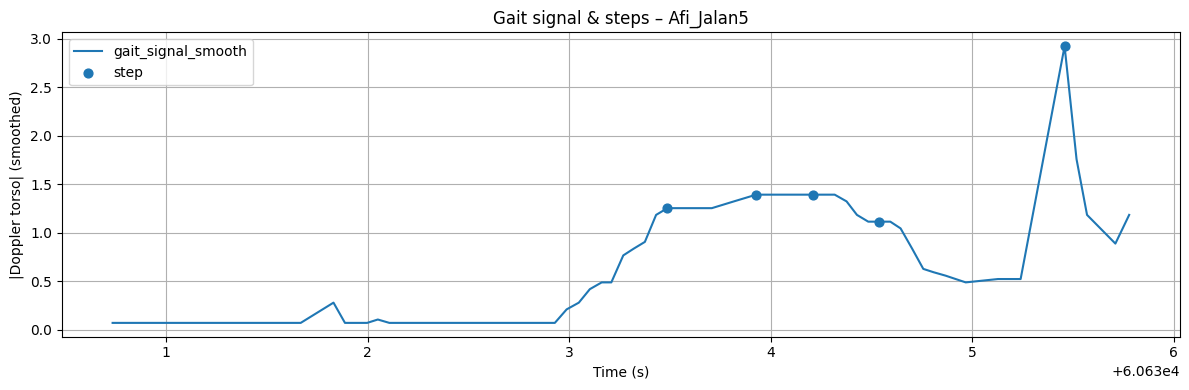

In [8]:
# Ganti nama file trial sesuai yang ada di folder gaitframe
sample_file = os.path.join(FOLDER_GAITFRAME, "Afi_Jalan5_gait_frame.csv")

df_steps, step_idxs = process_single_gait_frame_file(
    sample_file,
    save_to_folder=FOLDER_GAITFRAME_STEPS,
    smooth_window=5,
    min_step_time=0.3,
    max_step_time=1.5,
    threshold_alpha=0.4,
    do_plot=True  # supaya kelihatan bentuk sinyal & posisi step
)


In [7]:
df_sum = process_all_gait_frames_to_steps()
df_sum



=== Proses gait frame: Afi_Jalan10 ===
Load: E:\1.Clustering_TA\dataset\gaitframe\Afi_Jalan10_gait_frame.csv
Estimasi fps ≈ 18.142 frame/s
Jumlah step terdeteksi: 6
Saved: E:\1.Clustering_TA\dataset\gaitframe_steps\Afi_Jalan10_gait_with_steps.csv

=== Proses gait frame: Afi_Jalan11 ===
Load: E:\1.Clustering_TA\dataset\gaitframe\Afi_Jalan11_gait_frame.csv
Estimasi fps ≈ 18.204 frame/s
Jumlah step terdeteksi: 6
Saved: E:\1.Clustering_TA\dataset\gaitframe_steps\Afi_Jalan11_gait_with_steps.csv

=== Proses gait frame: Afi_Jalan12 ===
Load: E:\1.Clustering_TA\dataset\gaitframe\Afi_Jalan12_gait_frame.csv
Estimasi fps ≈ 18.054 frame/s
Jumlah step terdeteksi: 7
Saved: E:\1.Clustering_TA\dataset\gaitframe_steps\Afi_Jalan12_gait_with_steps.csv

=== Proses gait frame: Afi_Jalan13 ===
Load: E:\1.Clustering_TA\dataset\gaitframe\Afi_Jalan13_gait_frame.csv
Estimasi fps ≈ 18.195 frame/s
Jumlah step terdeteksi: 4
Saved: E:\1.Clustering_TA\dataset\gaitframe_steps\Afi_Jalan13_gait_with_steps.csv

=== Pro

,trial,n_frames,n_steps,n_gap_frames
0,Afi_Jalan10,79,6,2
1,Afi_Jalan11,82,6,6
2,Afi_Jalan12,110,7,16
3,Afi_Jalan13,59,4,0
4,Afi_Jalan14,78,2,11
...,...,...,...,...
211,Miftah_Jalan71,265,14,12
212,Miftah_Jalan72,366,26,9
213,Miftah_Jalan7,102,8,0
214,Miftah_Jalan8,101,9,4
